In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneOut, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## HAPT Data

In [2]:
label_dict = {4:0, 5:1}

In [3]:
X_train = pd.read_csv("../data/HAPT/Train/X_train.txt", header=None, sep=" ")
y = pd.read_csv("../data/HAPT/Train/y_train.txt", header=None).rename(columns={0:"label"})
X_train["label"] = y.label
X_train = X_train.sample(frac=1., random_state=0).reset_index(drop=True)

X_test = pd.read_csv("../data/HAPT/Test/X_test.txt", header=None, sep=" ")
y = pd.read_csv("../data/HAPT/Test/y_test.txt", header=None).rename(columns={0:"label"})
X_test["label"] = y.label 

In [4]:
X_train.shape, X_test.shape

((7767, 562), (3162, 562))

In [5]:
np.unique(X_train.label, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([1226, 1073,  987, 1293, 1423, 1413,   47,   23,   75,   60,   90,
          57]))

In [6]:
train_idx = X_train.label.isin([4,5])
np.unique(X_train[train_idx].label, return_counts=True)

(array([4, 5]), array([1293, 1423]))

In [7]:
# Sitting vs standing
train_idx = X_train.label.isin([4,5])
X_train = X_train[train_idx].reset_index(drop=True)
X_train["label"] = X_train["label"].map(label_dict)

test_idx = X_test.label.isin([4,5])
X_test = X_test[test_idx].reset_index(drop=True)
X_test["label"] = X_test["label"].map(label_dict)
y_test = X_test["label"]

In [8]:
X_train.shape, X_test.shape

((2716, 562), (1064, 562))

In [9]:
np.unique(X_train.label, return_counts=True)

(array([0, 1]), array([1293, 1423]))

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,label
0,0.036318,0.009213,-0.022781,-0.979810,-0.944017,-0.985647,-0.981478,-0.944016,-0.988402,-0.790631,-0.712094,-0.712342,0.821769,0.686632,0.665501,-0.973816,-0.999726,-0.998492,-0.999816,-0.986011,-0.950151,-0.991098,-0.535192,-0.214274,-0.613912,0.064710,-0.042028,-0.100442,0.154899,0.051472,-0.047801,0.057855,-0.044692,0.254859,-0.023199,0.005500,-0.085518,-0.845875,0.076199,-0.030622,0.631223,0.465987,0.396664,-0.980060,-0.955054,-0.981396,-0.981950,-0.957031,-0.984878,0.567575,0.445331,0.399341,0.647852,0.472945,0.395157,0.718894,0.125422,-0.552241,-0.697896,-0.985719,-0.961733,-0.994700,-0.464595,-0.177447,-0.476179,-0.672617,0.671080,-0.669700,0.668484,-0.750318,0.746357,-0.742745,0.738759,-0.838071,0.841010,-0.843723,0.845200,-0.952354,-0.791389,0.641034,0.068964,0.034340,-0.016392,-0.985033,-0.979880,-0.984877,-0.985698,-0.978462,-0.984180,-0.987237,-0.984547,-0.982128,0.979315,0.988292,0.984231,-0.984680,-0.999787,-0.999604,-0.999663,-0.986781,-0.981194,-0.983132,-0.629582,-0.608879,-0.638879,0.103571,0.055504,0.051630,0.356440,0.166036,0.056740,0.258298,0.106142,0.185028,0.137730,0.255557,0.123647,-0.043196,0.157030,-0.024316,-0.058668,-0.068326,0.023209,-0.982135,-0.955257,-0.944102,-0.980141,-0.957556,-0.945255,-0.912931,-0.953559,-0.689654,0.828083,0.835659,0.806200,-0.908105,-0.999208,-0.998054,-0.991058,-0.977991,-0.961459,-0.938587,-1.000000,-0.822897,0.464540,0.073737,-0.154929,0.235506,-0.277911,-0.535085,0.392329,0.011253,-0.047272,-0.304121,0.168195,0.089889,-0.200677,0.316932,-0.474035,0.262878,-0.086221,-0.026111,-0.087772,-0.987074,-0.976662,-0.962830,-0.988801,-0.984018,-0.970092,-0.985450,-0.961118,-0.950518,0.983194,0.982392,0.963416,-0.982863,-0.999867,-0.999671,-0.999086,-0.990825,-0.993374,-0.983896,-0.492836,-0.402700,-0.319858,0.111077,0.117317,0.040485,0.422970,-0.398893,0.243556,-0.073778,0.3319

# Logreg

In [11]:
def get_predictions(x):
    return [1 if xi >= 0.5 else 0 for xi in x]

In [12]:
X, y = X_train[[col for col in X_train.columns if col != "label"]].values , X_train.label

In [13]:
X.shape, y.shape

((2716, 561), (2716,))

In [14]:
loo = KFold(n_splits=10)
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    _X_train, _X_test = X[train_index, :], X[test_index,:]
    _y_train = y[train_index].values
    clf = LogisticRegression(random_state=0, C=1., max_iter=500).fit(_X_train, _y_train)
    preds[test_index] = clf.predict_proba(_X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Models AUC score: 0.9925584489485794
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1293
           1       0.96      0.96      0.96      1423

    accuracy                           0.96      2716
   macro avg       0.96      0.96      0.96      2716
weighted avg       0.96      0.96      0.96      2716



In [15]:
# Logreg MLE
log_reg = LogisticRegression(random_state=0, C=1.0, max_iter = 500).fit(X[:561,:], y[:561])

In [16]:
_X_test = X_test[[col for col in X_test.columns if col != "label"]].values
y_pred = log_reg.predict_proba(_X_test)[:,1]

In [17]:
print(f"Models AUC score: {roc_auc_score(y_test, y_pred)}")

Models AUC score: 0.9722355973488925


## Small logreg model

In [18]:
sort_idx = np.argsort(np.abs(log_reg.coef_))
sort_coef_vals = np.abs(log_reg.coef_)[0][sort_idx[0]]

In [19]:
len(sort_coef_vals[sort_coef_vals > 0.1])

203

In [20]:
feature_idx = sort_idx[0][-195:]

In [21]:
loo = KFold(n_splits=10)
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    _X_train, _X_test = X[:,feature_idx][train_index], X[:,feature_idx][test_index]
    _y_train = y[train_index]
    clf = LogisticRegression(random_state=0, C=1., max_iter=500).fit(_X_train, _y_train)
    preds[test_index] = clf.predict_proba(_X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Models AUC score: 0.9927024754625018
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1293
           1       0.97      0.96      0.97      1423

    accuracy                           0.96      2716
   macro avg       0.96      0.96      0.96      2716
weighted avg       0.96      0.96      0.96      2716



In [22]:
# Logreg MLE
log_reg = LogisticRegression(random_state=0, C=1.0, max_iter = 500).fit(X[:561,feature_idx], y[:561])

In [23]:
_X_test = X_test[[col for col in X_test.columns if col != "label"]].values
y_pred = log_reg.predict_proba(_X_test[:,feature_idx])[:,1]

In [24]:
print(f"Models AUC score: {roc_auc_score(y_test, y_pred)}")

Models AUC score: 0.9710849430691667


# Gaussian logreg

## MAP l2 estimate C=0.3

In [25]:
loo = KFold(n_splits=10)
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    _X_train, _X_test = X[train_index, :], X[test_index,:]
    _y_train = y[train_index].values
    clf = LogisticRegression(random_state=0, C=.3, max_iter=500).fit(_X_train, _y_train)
    preds[test_index] = clf.predict_proba(_X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Models AUC score: 0.9909942666577533
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1293
           1       0.96      0.96      0.96      1423

    accuracy                           0.96      2716
   macro avg       0.96      0.96      0.96      2716
weighted avg       0.96      0.96      0.96      2716



In [26]:
log_reg = LogisticRegression(random_state=0, C=.3, penalty="l2", max_iter = 500).fit(X[:561,:], y[:561])

In [27]:
_X_test = X_test[[col for col in X_test.columns if col != "label"]].values
y_pred = log_reg.predict_proba(_X_test)[:,1]
print(f"Models AUC score: {roc_auc_score(y_test, y_pred)}")

Models AUC score: 0.9718426046564324


## Small MAP logreg model

In [28]:
sort_idx = np.argsort(np.abs(log_reg.coef_))
sort_coef_vals = np.abs(log_reg.coef_)[0][sort_idx[0]]

In [29]:
feature_idx = sort_idx[0][-195:]

In [30]:
loo = KFold(n_splits=10)
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    _X_train, _X_test = X[:,feature_idx][train_index], X[:,feature_idx][test_index]
    _y_train = y[train_index]
    clf = LogisticRegression(random_state=0, C=.3, penalty="l2", max_iter=500).fit(_X_train, _y_train)
    preds[test_index] = clf.predict_proba(_X_test)[:,1]

print(f"Models AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Models AUC score: 0.9903947902620683
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1293
           1       0.96      0.95      0.96      1423

    accuracy                           0.96      2716
   macro avg       0.96      0.96      0.96      2716
weighted avg       0.96      0.96      0.96      2716



In [31]:
# Logreg MLE
log_reg = LogisticRegression(random_state=0, C=.3, penalty="l2", max_iter=500).fit(X[:561,feature_idx], y[:561])

In [32]:
_X_test = X_test[[col for col in X_test.columns if col != "label"]].values
y_pred = log_reg.predict_proba(_X_test[:,feature_idx])[:,1]

In [33]:
print(f"Models AUC score: {roc_auc_score(y_test, y_pred)}")

Models AUC score: 0.9718886308276214


In [34]:
X_test.shape

(1064, 562)

# Slap-and-spike prior

In [35]:
X, y = X_train[[col for col in X_train.columns if col != "label"]].values[:561,:] , X_train.label[:561]

In [36]:
import pymc3 as pm
import theano as tt
from scipy.special import expit
from scipy.stats import norm, bernoulli

This is our slab and spike model

$$a \sim \mathcal{N}(0, 3)$$
$$\gamma_i \sim Bernoulli(p=0.1)$$
$$\alpha_i|\sigma_\beta \sim \mathcal{N}(0, \sigma_\beta)$$
$$e \sim \mathcal{N}(0, \sigma^2_eI_n)$$
$$y \sim \frac{1}{1+exp(-(a + \sum_{i=1}^N \gamma_i \alpha_i x_i + e))}$$

The model parameters are $\theta = \{\gamma_i, \alpha_i\}_i^N $. The $\gamma_i$ and $\alpha_i$ are modelled IID.

In [40]:
# This model is inspired by the following notebook
# https://www.kaggle.com/melondonkey/bayesian-spike-and-slab-in-pymc3
a_mu = 0
a_var = 3
prob = 0.1
gamma_mu = 0
gamma_var = 3
with pm.Model() as model:
    # priors inclusion probability
    gamma_i = pm.Bernoulli("gamma_i", prob, shape=X.shape[1])
    # a is the interception
    a = pm.Normal("a", mu=a_mu, sd=a_var)
    # The prior for the features varibles which are included
    alpha = pm.Normal("alpha", mu=0, sd=gamma_var, shape=X.shape[1])
    # Deterministic function
    p = pm.math.dot(X,gamma_i * alpha) 
    # Likelihood
    y_obs = pm.Bernoulli("y_obs", pm.invlogit(p + a),  observed=y)
 

In [41]:
X.shape

(561, 561)

In [42]:
with model:
    trace = pm.sample(4000, random_seed = 37, cores = 1, progressbar = True, chains = 1)
    

/var/folders/bx/2b_70g054qg3qt5jhnw30xv40000gn/T/ipykernel_31235/321670048.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(4000, random_seed = 37, cores = 1, progressbar = True, chains = 1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>BinaryGibbsMetropolis: [gamma_i]
>NUTS: [alpha, a]


Sampling 1 chain for 1_000 tune and 4_000 draw iterations (1_000 + 4_000 draws total) took 615 seconds.
There were 254 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


# Map estimate

The log loss for the spike and slap prior
$$p(\theta) = p(\{\gamma_i, \alpha_i\}_i^N) = \prod_{i=1}^N p(\gamma_i) p(\alpha_i)$$

$$\log p(\theta) = \sum_{i=1}^N \log Bernoulli(\gamma_i | p=0.1) + \log \mathcal{N}(\alpha_i | \mu=0, \sigma_\beta=3)$$

In [43]:
def spike_slab_log_prior(gamma: np.array, alpha: np.array, p, gamma_mu=0, sigma_beta=3):
    return (bernoulli.logpmf(gamma, p=p) + norm.logpdf(alpha, loc=gamma_mu, scale=sigma_beta)).sum()

The negative log likelihood function, i.e. cross entropy

$$E(\mathbf{w}) = -log(p(\pmb{\mathbf{t}}|\pmb{\mathbf{x}},\mathbf{w})) \nonumber$$

$$= - \sum_{n=1}^N \left( t_n \ln y(\mathbf{x}_n) + (1-t_n) \ln (1-y(\mathbf{x}_n)) \right)$$
  

In [44]:
def log_likelihood(a, gamma, alpha, X, T):
    y_x = expit(a + np.dot(X, np.transpose(gamma*alpha)))
    return (T*np.log(y_x) + ((1-T)*np.log(1-y_x))).sum()

In [45]:
prob = 0.1
gamma_mu = 0
sigma_beta = 3

def find_spike_slab_MAP(trace, X, y, prob, gamma_mu, sigma_beta):
    min_loss = np.inf
    cur_min = -1
    for i in range(len(trace)):
        tmp_trace = trace[i]
        tmp_spike_slab_log_prior = spike_slab_log_prior(tmp_trace["gamma_i"], tmp_trace["alpha"], p=prob, gamma_mu=gamma_mu, sigma_beta=sigma_beta)
        tmp_log_likelihood = log_likelihood(tmp_trace["a"], tmp_trace["gamma_i"], tmp_trace["alpha"], X, y)
        neq_loss = -(tmp_log_likelihood + tmp_spike_slab_log_prior)
        if neq_loss <= min_loss:
            min_loss = neq_loss
            cur_min = i
    return trace[cur_min]
    

In [46]:
map_trace = find_spike_slab_MAP(trace, X, y, prob, gamma_mu, sigma_beta)

In [47]:
map_estimate = map_trace["gamma_i"] * map_trace["alpha"]

_X_test = X_test[[col for col in X_test.columns if col != "label"]].values
map_preds = expit(map_trace["a"] + np.dot(_X_test, np.transpose(map_estimate)))

In [48]:
print(f"Models AUC score: {roc_auc_score(y_test, map_preds)}")

Models AUC score: 0.958303829377443


## Bayesian inference

In [51]:
estimate = trace['alpha'] * trace['gamma_i'] 
_X_test = X_test[[col for col in X_test.columns if col != "label"]].values
preds = np.apply_along_axis(np.mean, 1, expit(trace['a'] + np.dot(_X_test, np.transpose(estimate) )) )


In [52]:
print(f"Models AUC score: {roc_auc_score(y_test, preds)}")

Models AUC score: 0.9688473630544383


In [53]:
preds[:10]

array([0.99760798, 0.98642032, 0.94972805, 0.985714  , 0.97809584,
       0.98117901, 0.96061033, 0.94970475, 0.85093135, 0.91831327])

In [54]:
map_preds[:10]

array([0.99999689, 0.99811571, 0.99671541, 0.99982275, 0.99699455,
       0.99662079, 0.9647681 , 0.93711131, 0.92795153, 0.96228175])

In [55]:
(map_preds[map_preds > 0.5]).mean(), (map_preds[map_preds <= 0.5]).mean()

(0.9362715444112103, 0.07103739034326795)

In [56]:
(preds[preds > 0.5]).mean(), (preds[preds <= 0.5]).mean()

(0.9173614327656769, 0.10676654721909952)

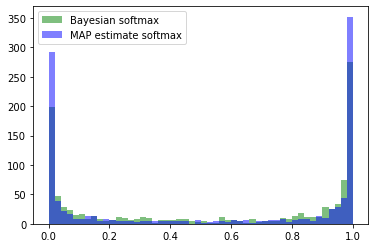

In [57]:
plt.hist(preds, bins=50, color="green", alpha=0.5, label="Bayesian softmax")
plt.hist(map_preds, bins=50, color="blue", alpha=0.5, label="MAP estimate softmax")
plt.legend()
plt.show()


# Random forrest and descision tree

In [58]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [59]:
X, y = X_train[[col for col in X_train.columns if col != "label"]].values[:561,:] , X_train.label[:561]

In [60]:
X.shape

(561, 561)

In [61]:
# grid search for params

rfc = RandomForestClassifier(max_depth=15, max_features=200).fit(X, y)

In [62]:
rfc_preds = rfc.predict_proba(_X_test)[:,1]

In [63]:
print(f"Models AUC score: {roc_auc_score(y_test, rfc_preds)}")

Models AUC score: 0.9318635642666968


## Descision tree

In [64]:
dfc = DecisionTreeClassifier(max_depth=10, max_features=200).fit(X, y)
dfc_preds = dfc.predict_proba(_X_test)[:,1]

In [65]:
print(f"Models AUC score: {roc_auc_score(y_test, dfc_preds)}")

Models AUC score: 0.8039993202288562


## Naive bayes

In [66]:
from sklearn.naive_bayes import GaussianNB

In [67]:
clf = GaussianNB()
clf.fit(X, y)


GaussianNB()

In [68]:
nb_preds = clf.predict_proba(_X_test)[:,1]

In [69]:
print(f"Models AUC score: {roc_auc_score(y_test, nb_preds)}")

Models AUC score: 0.6534760380671839
